## Notebook as scratch space

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
import pandas as pd

import torchvision

import os

In [2]:
train_dir = 'C:/Users/elise/Master thesis/Explaining_Prototypes_XAI_loop/data/CUB_200_2011/datasets/cub200_cropped/train_cropped'
test_dir = 'C:/Users/elise/Master thesis/Explaining_Prototypes_XAI_loop/data/CUB_200_2011/datasets/cub200_cropped/test_cropped'

img_size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_batch_size = 80
test_batch_size = 100

In [3]:
normalize = transforms.Normalize(mean=mean,
                                    std=std)
image_datasets = {
    'train':datasets.ImageFolder(
    train_dir,
    transforms.Compose([
        transforms.Resize(size=(img_size, img_size)),
        transforms.ToTensor(),
        normalize,
    ])),
    'test':
    datasets.ImageFolder(
        test_dir,
        transforms.Compose([
            transforms.Resize(size=(img_size, img_size)),
            transforms.ToTensor(),
            normalize,
        ]))
 }

train_set_size = int(len(image_datasets['train']) * 0.8)
valid_set_size = len(image_datasets['train']) - train_set_size
train_set , valid_set = torch.utils.data.random_split(image_datasets['train'],[train_set_size,valid_set_size])
print(type(image_datasets['train']))
print(type(train_set))
print((len(train_set)))
print((len(valid_set)))


<class 'torchvision.datasets.folder.ImageFolder'>
<class 'torch.utils.data.dataset.Subset'>
4795
1199


In [8]:
dataloaders = {
    'train':
    torch.utils.data.DataLoader(
    train_set, batch_size=train_batch_size, shuffle=True,
    num_workers=4, pin_memory=False),
    'validation':
    torch.utils.data.DataLoader(
    valid_set, batch_size=train_batch_size, shuffle=True,
    num_workers=4, pin_memory=False),
    'test':
    torch.utils.data.DataLoader(
    image_datasets['test'], batch_size=test_batch_size, shuffle=False,
    num_workers=4, pin_memory=False)

}
print(len(dataloaders['train']))

60


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#ResNet50_Weights.IMAGENET1K_V1
# ResNet50_Weights.DEFAULT
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 200)).to(device)
            #    nn.Linear(2048, 128),
            #    nn.ReLU(inplace=True),
            #    nn.Linear(128, 200)).to(device)



criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

print(type(criterion))
print(type(optimizer))
print(type(device))

cuda:0
<class 'torch.nn.modules.loss.CrossEntropyLoss'>
<class 'torch.optim.adam.Adam'>
<class 'torch.device'>


In [6]:
def train_model(model, criterion, optimizer, num_epochs):
    history = pd.DataFrame(
    columns = ['train_loss', 'validation_loss']
    )
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        dataset_size = 0
        for phase in ['train', 'validation']:
            if phase == 'train':
                dataset_size = len(train_set)
                model.train()
            else:
                dataset_size = len(valid_set)
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size

            history.loc[epoch, phase + '_loss'] = epoch_loss
            # history.loc[epoch, phase + '_accuracy'] = epoch_acc

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model, history



In [ ]:
model_trained, history = train_model(model, criterion, optimizer, num_epochs=15)

In [ ]:
def makedir(path):
    if not os.path.exists(path):
        os.makedirs(path)  

In [ ]:
model_save_path = 'C:/Users/elise/Master thesis/Explaining_Prototypes_XAI_loop/Resnet50/trained_models'

makedir(model_save_path)

In [ ]:
torch.save(model_trained.state_dict(), model_save_path +'/weights_imagenetv2_epoch15.h5')

In [ ]:
loaded_model = resnet50(weights=None).to(device)
loaded_model.fc = nn.Sequential(
               nn.Linear(2048, 200)).to(device)
            #     nn.Linear(2048, 128),
            #    nn.ReLU(inplace=True),
            #    nn.Linear(128, 200)).to(device)
            
loaded_model.load_state_dict(torch.load('trained_models/weights_imagenetv2_epoch15.h5'))

<All keys matched successfully>

<Axes: >

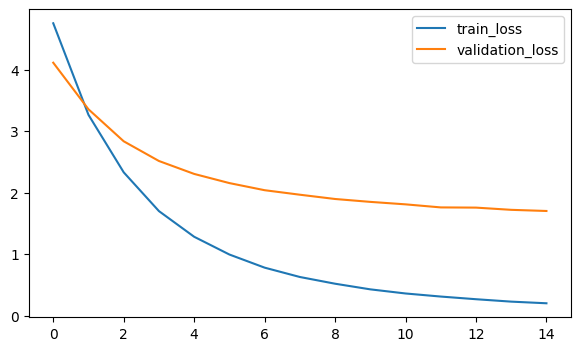

In [ ]:
history.plot( y= ['train_loss', 'validation_loss'], kind='line', figsize=(7,4))

In [ ]:
loaded_model.eval()
with torch.no_grad():
    n_correct = 0
    for i, (inputs,labels) in enumerate(dataloaders['test']):
        inputs =inputs.to(device)
        labels = labels.to(device)

        outputs = loaded_model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        n_correct += torch.sum(predicted == labels.data)
    accuracy = n_correct/len(image_datasets['test'])
    print(accuracy)

tensor(0.6099, device='cuda:0')


<Axes: >

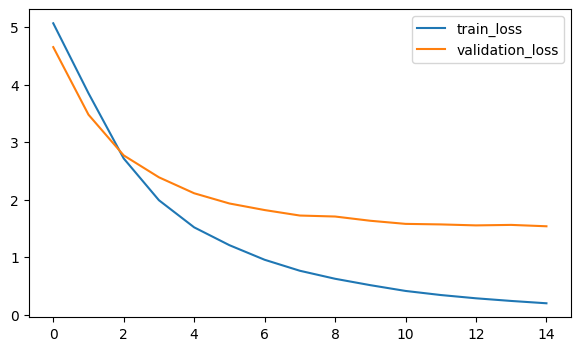

In [49]:
history.plot( y= ['train_loss', 'validation_loss'], kind='line', figsize=(7,4))